# Correcting hydration free energies using support vector machines

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Path variables</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Model-hyper-parameter-statistics" data-toc-modified-id="Model-hyper-parameter-statistics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model hyper-parameter statistics</a></span></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#$\Delta-\Delta-G_{offset}$-correction" data-toc-modified-id="$\Delta-\Delta-G_{offset}$-correction-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>$\Delta \Delta G_{offset}$ correction</a></span></li><li><span><a href="#$\Delta-\Delta-G_{hydr}$-correction" data-toc-modified-id="$\Delta-\Delta-G_{hydr}$-correction-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>$\Delta \Delta G_{hydr}$ correction</a></span></li><li><span><a href="#Original-FreeSolve-$\Delta-\Delta-G_{hydr}$" data-toc-modified-id="Original-FreeSolve-$\Delta-\Delta-G_{hydr}$-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Original FreeSolve $\Delta \Delta G_{hydr}$</a></span></li></ul></li></ul></div>

## Imports

In [51]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
import time
import shutil
import logging
import pickle
from tqdm import tqdm_notebook as tqdm

# Statistics:
import scipy
import statistics
from sklearn.metrics import r2_score

# Tensorflow:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# SciKit-Optimise:
from skopt import gp_minimize, dump, load
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

## Path variables

In [54]:
# Path variables:
path = './'
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
output_dr = path + 'output/'
figures_dr = path + 'figures/'
freesolv_loc = datasets_dr + 'freesolv_database.txt'

## Global variables

In [22]:
# Global variables:
model_type = 'DNN'
label_col = 'dGoffset (kcal/mol)'

# DNN global variables
n_calls = 20  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
epochs = 200
best_mae = np.inf

# load in data set
dtrain_df = pd.read_hdf(datasets_dr + 'dtrain_data.h5', key='relative')
num_input_nodes = len(dtrain_df.columns) - 1

## Load data

In [21]:
# external test set
dtest_df = pd.read_hdf(datasets_dr + 'dtest_data.h5', key='relative')
# gp_minimize object
search_result = load(output_dr + 'gp_minimize_result.pickle')
# trained model
model = tf.keras.models.load_model(output_dr + 'ddGhydr_' + model_type + '_model.h5')
# lsit of MAE and associated parameters
mae_lst = pd.read_csv(output_dr + 'DNN_statistics.csv')

## Model hyper-parameter statistics

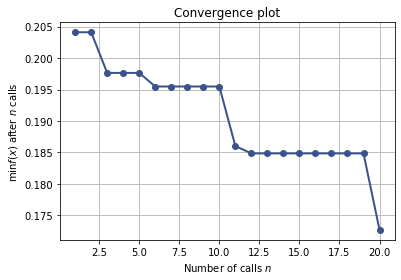

In [11]:
plot_convergence(search_result)

## External testing

In [42]:
def plot_scatter(dataframe, x_info, y_info, title, MAE):
    """x and y info are lists with format [dataframe column index, axis label]."""

    # x and y data
    x = dataframe.iloc[:, x_info[0]]
    y = dataframe.iloc[:, y_info[0]]

    # plot scatter
    plt.figure()
    plt.scatter(x, y,
                color='black',
                s=8)

    # plot line of best fit
    # https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
    plt.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black',
             linewidth=1)

    # axis labels
    plt.xlabel(x_info[1])
    plt.ylabel(y_info[1])

    plt.title(title)

    # R-squared
    r2 = r2_score(x, y)

    # annotate with r-squared and MAE
    string = 'R-squared = {}\nMAE = {}'.format(round(r2, 4), round(MAE, 4))
    plt.annotate(string,
                 xy=(0, 1),
                 xytext=(12, -12),
                 va='top',
                 xycoords='axes fraction',
                 textcoords='offset points')

    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    print('Saved', filename)

### $\Delta \Delta G_{offset}$ correction

In [35]:
# unpack testing set
dtest_id = dtest_df.index.tolist()
dtest_X = dtest_df.drop(columns=label_col).values
dtest_y = dtest_df[label_col].values

In [44]:
# predict
dpredict_y = model.predict(dtest_X)
# convert np array to float
dpredict_y = [float(x) for x in dpredict_y]
# calculate absolute error
dpredict_ae = [abs(predict - test) for predict, test in zip(dpredict_y, dtest_y)]
# calculate mean absolute error
mae = statistics.mean(dpredict_ae)

In [94]:
dpredict_df = pd.DataFrame(
    zip(dtest_id, predict_y, dtest_y, dpredict_ae),
    columns=['ID', 'Predicted ddGoffset (kcal/mol)', 'Experimental ddGoffset (kcal/mol)', 'Absolute error (kcal/ml)']
)
dpredict_df = dpredict_df.set_index('ID')

In [52]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dpredict_df.iloc[:, 1], dpredict_df.iloc[:, 0])
r2 = r_value**2
r2

0.38122590688707586

Saved ./figures/ddgoffset_prediction.png


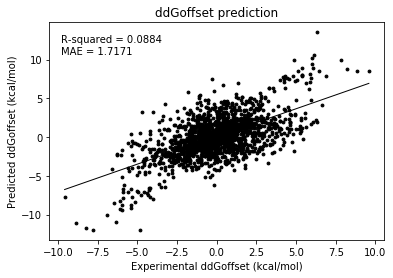

In [49]:
plot_scatter(dataframe=dpredict_df,
             x_info=[1, 'Experimental ddGoffset (kcal/mol)'],
             y_info=[0, 'Predicted ddGoffset (kcal/mol)'],
             title='ddGoffset prediction',
             MAE=mae)

$offset(x) = exp(x) - calc(x)$

$\Rightarrow exp(x) = offset(x) + calc(x)$

$\Rightarrow correction(x) = offset(x) + calc(x)$

$\Delta offset = offset(a) - offset(b)$

$\Delta correction(x) = \Delta offset(x) + \Delta calc(x)$

### $\Delta \Delta G_{hydr}$ correction

In [55]:
# Load in FreeSolve
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python')

In [70]:
# SAMPL4 Gurthrie df
test_fs_df = freesolv_df.loc[freesolv_df.iloc[:, 7] == 'SAMPL4_Guthrie'].sort_index()

# experimentally determined dGhydr
test_exp = test_fs_df.iloc[:, 3].tolist()
dtest_exp = [x - y for x in test_exp for y in test_exp if not x - y == 0]

# computationally calculated dGhydr
test_calc = test_fs_df.iloc[:, 5].tolist()
dtest_calc = [x - y for x in test_calc for y in test_calc if not x - y == 0]

In [81]:
# correction
dcorrection = [prediction + calc for prediction, calc in zip(dpredict_df.iloc[:, 0], dtest_calc)]
# calcualte absolute error
dcorrection_ae = [abs(correction - exp) for correction, exp in zip (dcorrection, dtest_exp)]
# calculate mean absolute error
dcorrection_mae = statistics.mean(dcorrection_ae)

In [76]:
dcorrection_df = pd.DataFrame(zip(dtest_id, dcorrection, dtest_exp),
                             columns=['ID', 'dGhydr(calc + ML) (kcal/mol)', 'dGhydr(exp) (kcal/mol)'])
dcorrection_df = dcorrection_df.set_index('ID')

In [77]:
dslope, dintercept, dr_value, dp_value, dstd_err = scipy.stats.linregress(dcorrection_df.iloc[:, 1], dcorrection_df.iloc[:, 0])
dr2 = dr_value**2
dr2

0.6699492788039177

Saved ./figures/dnn_corrected_ddghydr.png


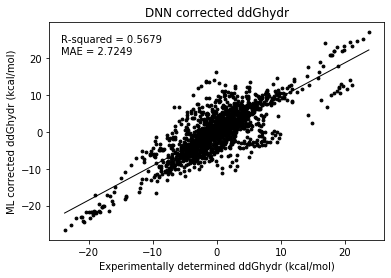

In [82]:
plot_scatter(dataframe=dcorrection_df,
             x_info=[1, 'Experimentally determined ddGhydr (kcal/mol)'],
             y_info=[0, 'ML corrected ddGhydr (kcal/mol)'],
             title='DNN corrected ddGhydr',
             MAE=dcorrection_mae)

### Original FreeSolve $\Delta \Delta G_{hydr}$

In [91]:
dfreesolv_ae = [abs(calc - exp) for calc, exp in zip(dtest_calc, dtest_exp)]
dfreesolv_mae = statistics.mean(freesolv_ae)

dfreesolv_df = pd.DataFrame(zip(dtest_id, dtest_calc, dtest_exp, dfreesolv_ae),
                       columns=['ID', 'Computationally calculated ddGhydr (kcal/mol)',
                               'Experimentally determined ddGhydr (kcal/mol)', 
                               'Absolute error (kcal/mol)'])
dfreesolv_df = dfreesolv_df.set_index('ID')

In [92]:
fs_slope, fs_intercept, fs_r_value, fs_p_value, fs_std_err = scipy.stats.linregress(dfreesolv_df.iloc[:, 1], dfreesolv_df.iloc[:, 0])
fs_r2 = fs_r_value**2
fs_r2

0.5907326276107897

Saved ./figures/original_freesolve_ddghydr.png


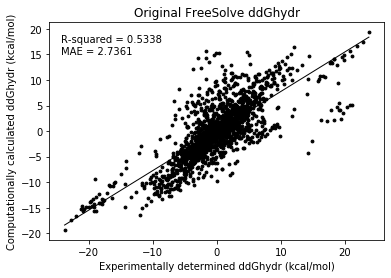

In [93]:
plot_scatter(dataframe=dfreesolv_df,
             x_info=[1, 'Experimentally determined ddGhydr (kcal/mol)'],
             y_info=[0, 'Computationally calculated ddGhydr (kcal/mol)'],
             title='Original FreeSolve ddGhydr',
             MAE=dfreesolv_mae)